In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import string 
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt 
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [ ]:
! gdown --id 1vexo0MMtjPzSv5CONn5t8QH3IKvewedk
reviewData = pd.read_csv("/content/labeledTrainData.tsv", delimiter="\t")
reviewData.head()

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vexo0MMtjPzSv5CONn5t8QH3IKvewedk
To: /content/labeledTrainData.tsv
100% 33.6M/33.6M [00:00<00:00, 38.2MB/s]


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [ ]:
reviewsAll = reviewData['review'].values
sentimentsAll = reviewData['sentiment'].values
reviews, reviews_test, sentiments, sentiments_test = train_test_split(reviewsAll, sentimentsAll, test_size=0.2, random_state=RANDOM_SEED)
sentimentClasses = np.unique(sentimentsAll)


In [ ]:
ReviewsByClass = {} 
ReviewsByClass[0] = []
ReviewsByClass[1] = []
for i in range(len(sentiments)):
  if sentiments[i] == 0:
    ReviewsByClass[0].append(reviews[i])
  else:
    ReviewsByClass[1].append(reviews[i])


In [ ]:
PriorProbabilityByClass = {}
for i in range(2):
  PriorProbabilityByClass[i] = math.log(len(ReviewsByClass[i])/len(reviewsAll))
print(PriorProbabilityByClass)

{0: -0.9143925345910748, 1: -0.9181925391637514}


In [ ]:
def tokenize(review):
    review = review.lower()
    review = review.replace("\\", '')
    review = review.split()
    return review


In [ ]:
BagOfWordsByClass = {}
BagOfWordsByClass[0] = {}
BagOfWordsByClass[1] = {}
vocab = set()

for j in range(2): 
  for i in range(len(ReviewsByClass[j])):
    words = tokenize(ReviewsByClass[j][i])
    for k in range(len(words)):
      if words[k] in BagOfWordsByClass[j]:
        BagOfWordsByClass[j][words[k]] += 1
      else:
        BagOfWordsByClass[j][words[k]] = 1
        vocab.add(words[k])


In [ ]:
posWordsInClass = sum(BagOfWordsByClass[1].values())
negWordsInClass = sum(BagOfWordsByClass[0].values())

def computePosteriorProbs(word, c, reviewsByClass, bagOfWordsByClass):
  if word not in bagOfWordsByClass[c]:
    bagOfWordsByClass[c][word] = 0
  if c == 1:
    wordsInClass = posWordsInClass
  else: 
    wordsInClass = negWordsInClass
  computePosteriorProbs = math.log((bagOfWordsByClass[c][word] + 1)/(wordsInClass + len(vocab)))
  return computePosteriorProbs


In [ ]:
classified_sentiments = [] 

for i in range(len(reviews_test)):
  reviewWords = tokenize(reviews_test[i])
  negProbability = PriorProbabilityByClass[0]
  posProbability = PriorProbabilityByClass[1]
  for word in reviewWords:
    if word in vocab:
      negProbability += computePosteriorProbs(word, 0, ReviewsByClass, BagOfWordsByClass)
      posProbability += computePosteriorProbs(word, 1, ReviewsByClass, BagOfWordsByClass)
  if negProbability > posProbability:
    classified_sentiments.append(0)
  else:
    classified_sentiments.append(1)
          

In [ ]:

accuracy_score(sentiments_test, classified_sentiments)

0.8476

In [ ]:
classification_report(sentiments_test, classified_sentiments)

'              precision    recall  f1-score   support\n\n           0       0.83      0.87      0.85      2481\n           1       0.86      0.83      0.85      2519\n\n    accuracy                           0.85      5000\n   macro avg       0.85      0.85      0.85      5000\nweighted avg       0.85      0.85      0.85      5000\n'

In [ ]:
def drawConfusionMatrix():
  cnf_data = confusion_matrix(sentiments_test, classified_sentiments)
  figure = plt.figure()
  axes = figure.add_subplot(111)
  caxes = axes.matshow(cnf_data, cmap='Blues')
  plt.title('Confusion Matrix')
  axes.set_xlabel("Predicted sentiment")
  axes.set_ylabel("Actual sentiment")
  axes.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
  axes.tick_params(axis="y", left=True, labelleft=True, rotation=90)
  labels = ['positive', 'negative']
  axes.set_xticklabels(['']+labels)
  axes.set_yticklabels(['']+labels)
  for (i, j), z in np.ndenumerate(cnf_data):
      axes.text(j, i, '{}'.format(z), ha='center', va='center', fontsize=15,
                bbox=dict(boxstyle='round', facecolor='white'))
  plt.grid(False)
  plt.show()

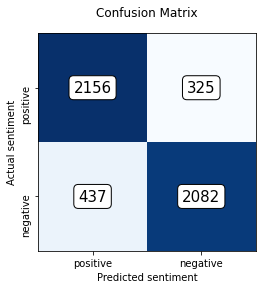

In [ ]:
drawConfusionMatrix()